> # Belief in Supernatural Evil and Guns

In this assignment we will replicate a study of belief in supernatural evil and attitudes towards guns in the United States.

The study is: 

*Christopher G. Ellison, Benjamin Dowd-Arrow, Amy M. Burdette, Pablo E. Gonzalez, Margaret S. Kelley, Paul Froese, "Peace through superior firepower: Belief in supernatural evil and attitudes toward gun policy in the United States", Social Science Research, Volume 99, 2021.*

and you can find it [here](https://doi.org/10.1016/j.ssresearch.2021.102595).

> # Introduction

### Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import re

from statsmodels.formula.api import logit
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.inspection import permutation_importance

from functions.features_selection import return_missing_data, return_race
from functions.logistic_and_linear_regression import run_logistic_regression, run_linear_regression
from functions.modeling import cross_validation_of_models, hyperparameter_tuning, model_evaluation, classification_prediction
from functions.feature_importance import get_feature_importances

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Read Data

The data used in the paper is the "Baylor Religion Survey, Wave IV (2014)" and is downloaded from [thearda.com](https://www.thearda.com/Archive/Files/Downloads/BRS2014ED_DL2.asp)

In [2]:
# load the excel file
df = pd.read_excel('./data/Baylor_data.xlsx')
                   
# preview
df

,MOTHERLODE_ID,PROJECT_ID,RESPONDENT_ID,METHOD_ID,METHOD_TYPE,PROJECT_NUMBER,CREATED_ON,PRACTICE,RESPONDENT_DATE,RESPONDENT_LANGUAGE,...,STATE,PROJWT,WEIGHT,Q2,RELTRAD,I_GENDER,I_EDUC,I_MARITAL,I_RELIGION,I_ATTEND
0,128170892,33370,01_000001_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,TX,20086.696606,0.270000,Church of Christ,1.0,2.0,5.0,3.0,1.0,6.0
1,128170893,33370,01_000002_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,TX,26218.573175,0.352423,Church of God In Christ,3.0,2.0,3.0,3.0,3.0,2.0
2,128170894,33370,01_000003_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,ND,41408.889891,0.556608,ELCA,2.0,2.0,3.0,1.0,2.0,6.0
3,128170895,33370,01_000004_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,TX,50023.027356,0.672397,Independent Methodist,2.0,2.0,4.0,3.0,2.0,5.0
4,128170896,33370,01_000005_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,IA,230734.428388,3.101474,Don't have specific name,1.0,1.0,2.0,2.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,128172920,33371,02_000301_00000013,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/10/2014,es-AR,...,CA,17054.912661,0.229248,NaN,4.0,2.0,5.0,2.0,4.0,2.0
1568,128172921,33371,02_000326_00000014,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/12/2014,es-AR,...,CA,104454.336796,1.404049,NaN,4.0,2.0,2.0,2.0,4.0,1.0
1569,128172922,33371,02_000351_00000015,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/19/2014,es-AR,...,CA,153453.642034,2.062685,NaN,6.0,2.0,3.0,1.0,5.0,6.0
1570,128172335,33371,02_000352_00000015,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/19/2014,es-AR,...,CT,33324.200008,0.447935,Catolica Romana - Latinos,4.0,1.0,5.0,2.0,4.0,3.0


We only want to keep the columns of interest, being aligned with the study, which are the following:



### <U>Dependent Variables<U>
- Ban on Semi-Auto Guns
- Ban on High-Capacity Ammo Clips
- Banning Civilian Handguns
- Support for Concealed Carry Laws
- More Armed Security at Schools
- More Teachers/Faculty having Guns
- More Gun Safety Programs
- Expanded Mental Health Screening

### <U>Independent Variables<U>

#### Religious Variables (Q17)
- Attendance
- Bible (Human Error, History, and Fables)
- Biblical Inerrancy
- Biblical Literalism

#### Religious Affiliation
- Conservative Protestant
- Mainline Protestant
- Black Protestant
- Catholic
- Other
- No Affiliation

#### Other Variables
- Political Ideology
- Age
- Sex
  - Female
  - Male
- Race
  - White
  - Hispanic
  - African American/Black
  - Other
- Education
  - Less Than High School
  - High School or Equivalent
  - Some College
  - College Degree
  - Post-graduate Degree
- Household Income
- Marital Status
  - Not Partnered/Single
  - Married/Cohabitating
- Children
  - No kids under 18 in home
  - Kids under 18 in home
- Area Demographics
  - Small Town/Rural
  - Urban Area
- Region
  - South
  - Other Region


From [Baylor Religion Survey, Wave IV (2014)](https://www.thearda.com/Archive/Files/Codebooks/BRS2014_CB.asp) we find the corresponding column names, and only keep those.

In [3]:
# keep wanted columns
columns_needed = ['Q73A', 'Q73E', 'Q73G', 'Q73H', 'Q73C', 'Q73F', 'Q73B', 'Q73D', # dependent variables
                  'Q23A', 'Q23C', 'Q23G', # supernatural
                  'Q4', 'Q17', # religious variables
                  'RELTRAD', # religious affiliation
                  'Q31', # political ideology
                  'AGE', 'AGE_VALID', # age
                  'Q77', # sex
                  'Q88A', 'Q89', 'Q88B', 'Q88F', # race
                  'Q90', # education
                  'Q95', # household income
                  'Q51A', # marital status
                  'Q93', 'Q93_NONE', # children
                  'Q80', # area demographics
                  'STATE' # region
                ]

# drop unwanted columns
df.drop(columns=[col for col in df if col not in columns_needed], inplace=True)

* We will rename the columns to represent the actual names of each variable

In [4]:
# rename dict mapping
rename_columns = {'Q73A' : 'Semi-Auto Weapons Ban', 'Q73E' : 'High-Capacity Magazine Ban', \
                  'Q73G' : 'Civilian Hand Gun Possession Ban', 'Q73H' : 'Support for Concealed Carry',\
                  'Q73C' : 'More Armed Security at Schools', 'Q73F' : 'More Teachers/Faculty with Guns', 
                  'Q73B' : 'Required Gun Safety Programs', 'Q73D' : 'Expanded Mental Health Screening', # dependent variables
                  'Q23A' : 'Devil', 'Q23C' : 'Hell', 'Q23G' : 'Demons', # supernatural
                  'Q4' : 'Attendance', 'Q17' : 'Biblical', # religious variables
                  'RELTRAD' : 'Religious Affiliation', # religious affiliation
                  'Q31' : 'Political Ideology', # political ideology
                  'AGE'  : 'Age', # age
                  'Q77' : 'Sex', # sex
                  'Q88A' : 'White' , 'Q89' : 'Hispanic', 'Q88B' : 'African American/Black', 'Q88F' : 'Other', # race
                  'Q90' : 'Education', # education
                  'Q95' : 'Income', # household income
                  'Q51A' : 'Marital Status', # marital status
                  'Q93' : 'Kids', 'Q93_NONE' : 'Kids_None', # children
                  'Q80' : 'Residence', # area demographics
                  'STATE' : 'State' # region
                
}

# rename dict
df.rename(rename_columns, axis=1, inplace=True)

In [5]:
# create a list with the study order
order = ['Semi-Auto Weapons Ban', 'High-Capacity Magazine Ban', 'Civilian Hand Gun Possession Ban', 'Support for Concealed Carry',
         'More Armed Security at Schools', 'More Teachers/Faculty with Guns', 'Required Gun Safety Programs', 'Expanded Mental Health Screening',
         'Devil', 'Hell', 'Demons',
         'Attendance', 
         'Biblical', 
         'Religious Affiliation',
         'Political Ideology',
         'White' , 'Hispanic', 'African American/Black', 'Other',
         'Sex',
         'Education',
         'Age',
         'Income',
         'Marital Status', 
         'Kids', 'Kids_None', 
         'Residence',
         'State'
        ]

# re-order df based on study order
df = df[order]

### Data Infos

In [6]:
df.head()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Devil,Hell,...,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence,State
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,...,NaN,2.0,6.0,85,2.0,5.0,NaN,1.0,4.0,TX
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,2.0,4.0,0,1.0,5.0,2.0,NaN,1.0,TX
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,2.0,...,2.0,2.0,4.0,67,3.0,1.0,NaN,NaN,3.0,ND
3,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,4.0,...,2.0,2.0,5.0,64,2.0,5.0,NaN,NaN,2.0,TX
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,4.0,...,2.0,1.0,3.0,54,5.0,2.0,2.0,NaN,1.0,IA


In [7]:
df.shape

(1572, 28)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Semi-Auto Weapons Ban             1502 non-null   float64
 1   High-Capacity Magazine Ban        1502 non-null   float64
 2   Civilian Hand Gun Possession Ban  1501 non-null   float64
 3   Support for Concealed Carry       1502 non-null   float64
 4   More Armed Security at Schools    1510 non-null   float64
 5   More Teachers/Faculty with Guns   1504 non-null   float64
 6   Required Gun Safety Programs      1515 non-null   float64
 7   Expanded Mental Health Screening  1512 non-null   float64
 8   Devil                             1504 non-null   float64
 9   Hell                              1499 non-null   float64
 10  Demons                            1492 non-null   float64
 11  Attendance                        1556 non-null   float64
 12  Biblic

In [9]:
df.describe()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Devil,Hell,...,African American/Black,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence
count,1502.000000,1502.000000,1501.000000,1502.000000,1510.000000,1504.000000,1515.000000,1512.000000,1504.000000,1499.000000,...,822.000000,672.00000,1536.000000,1501.000000,1572.000000,1467.000000,1554.000000,542.000000,704.0,1540.000000
mean,1.370839,1.328895,1.709527,1.442077,1.378146,1.705452,1.072607,1.091931,3.149601,3.088726,...,1.782238,1.91369,1.578776,5.006662,49.162214,4.151329,2.646718,1.326568,1.0,2.429221
std,0.483190,0.469968,0.454132,0.496799,0.485085,0.455991,0.259576,0.289024,1.108048,1.114655,...,0.412976,0.28103,0.493916,1.602900,21.018613,1.707939,1.591398,1.097129,0.0,1.186694
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,...,2.000000,2.00000,1.000000,4.000000,35.000000,3.000000,2.000000,0.000000,1.0,1.000000
50%,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,4.000000,4.000000,...,2.000000,2.00000,2.000000,5.000000,52.000000,5.000000,2.000000,1.000000,1.0,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,4.000000,4.000000,...,2.000000,2.00000,2.000000,6.000000,64.000000,5.000000,3.000000,2.000000,1.0,3.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,4.000000,...,2.000000,2.00000,2.000000,7.000000,99.000000,7.000000,6.000000,6.000000,1.0,8.000000


> # Section 1: Belief in Supernatural Evil Metric

In order to measure the belief in supernatural evil, we will use the answers to three questions asked by the participants in the survey:

* Whether the respondent believes in the devil.

* Whether the respondent believes in hell.

* Whether the respondent believes in demons.

We will investigate how the answers to these three questions can be combined to a single metric. 

In [10]:
# preview of data
df.head()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Devil,Hell,...,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence,State
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,...,NaN,2.0,6.0,85,2.0,5.0,NaN,1.0,4.0,TX
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,2.0,4.0,0,1.0,5.0,2.0,NaN,1.0,TX
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,2.0,...,2.0,2.0,4.0,67,3.0,1.0,NaN,NaN,3.0,ND
3,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,4.0,...,2.0,2.0,5.0,64,2.0,5.0,NaN,NaN,2.0,TX
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,4.0,...,2.0,1.0,3.0,54,5.0,2.0,2.0,NaN,1.0,IA


* Based on the study approach, the **three metrics were combined into one variable using the average of the values**.

In [11]:
# list with variables related to supernatura evil 
supernatural_evil = ['Devil', 'Hell', 'Demons']

# since we want only the responses, we drop nas
df_supernatural_evil = df[supernatural_evil].dropna()

#preview df
df_supernatural_evil.head()

,Devil,Hell,Demons
0,4.0,4.0,4.0
1,4.0,4.0,4.0
2,3.0,2.0,2.0
3,4.0,4.0,4.0
4,4.0,4.0,4.0


In [12]:
# compute the mean of the average of three columns and set it as an indicator
indicator = df_supernatural_evil.dropna().mean(axis=1).round().mean()

# preview
indicator

3.090909090909091

* We will investigate if the three metics can be combined in a single one, by running **Factor Analysis** or **PCA** (we will test both)

### Factor Analysis

* Step 1: **Bartlett’s Test**
    * We need to evaluate the “factorability” of our dataframe by doing a Bartlett’s Test.
    * Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. 
    * If the test found statistically insignificant, we should not employ a factor analysis.

In [13]:
# run Bartlett's test
chi_square_value,p_value = calculate_bartlett_sphericity(df_supernatural_evil)

# print results
chi_square_value, p_value

(4298.307341110505, 0.0)

In this Bartlett ’s test, the p-value is 0, The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix

* Step 2: **Kaiser-Meyer-Olkin (KMO) Test**
    * We need to do a Kaiser-Meyer-Olkin (KMO) Test which measures the suitability of data for factor analysis.
    * KMO estimates the proportion of variance among all the observed variable.
    * It is known that lower proportion id more suitable for factor analysis.
    * KMO values range between 0 to 1 and if the value of KMO is less than 0.6, then is considered inadequate.

In [14]:
# run KMO test
kmo_all,kmo_model = calculate_kmo(df_supernatural_evil)

# print results
kmo_model

0.7552206917260557

The overall KMO for our data is 0.76, which is excellent and indicates that we can proceed with our planned factor analysis

* Step 3: **Run Factor Analysis**
    * To succeed that, we can use the Kaiser criterion and scree plot. 
    * Both are based on eigenvalues.

In [15]:
# create factor analysis object with 1 factor
fa = FactorAnalyzer(1,rotation=None)

# fit the model to our data
fa.fit(df_supernatural_evil)

# get eigenvalues
ev, v = fa.get_eigenvalues()

print(f'The eigenvalues are: {ev}')
print(f'The explained variance ratio is: {fa.get_factor_variance()[2][0]}')

The eigenvalues are: [2.70509088 0.19033651 0.10457261]
The explained variance ratio is: 0.8540157007270278


* We have only one factor which eigenvalue is greater than one witch means that we can describe our data with one factor.
* Also, the explained variance ratio is 0.85 which shows very good explainability.
* We can can confirm the above, by creating a scree plot using matplotlib

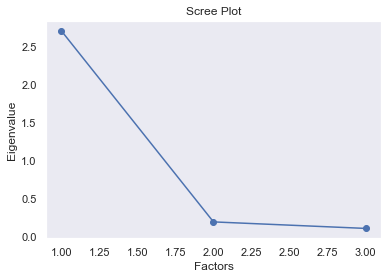

In [16]:
plt.scatter(range(1,df_supernatural_evil.shape[1]+1),ev)
plt.plot(range(1,df_supernatural_evil.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

* It is known that the scree plot method draws a straight line for each factor and its eigenvalues. 
* Number eigenvalues greater than one considered as the number of factors.
* So, we can choose only one factor to describe the supernatural evil variable and factor analysis is a good method to combine all three metrics,which comes in agreement with researchers's decision.

### PCA

* Step 1: **Feature Scaling ~ Normalization**
    * PCA is affected by feature scales, so we'll transform the data so that they have mean 0 and variance 1.

In [17]:
# create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# fit the scaler to the data, computing the minimum and maximum values for scaling
scaler.fit(df_supernatural_evil)

# transform the data using the computed minimum and maximum values
# this scales the data to a specified range, often between 0 and 1
df_supernatural_evil = scaler.transform(df_supernatural_evil)

In [18]:
# print cumulative variance 
fa.get_factor_variance()[2][0]

0.8540157007270278

* Step 2: **Run PCA for one component**

In [19]:
# create an instance of the PCA with 1 component
pca = PCA(n_components=1)

# fit the PCA model to the data, computing the principal components
pca.fit(df_supernatural_evil)

print(f'The explained variance ratio is: {pca.explained_variance_ratio_.sum()}')

The explained variance ratio is: 0.9017149549264374


* Based on the above, we can see that PCA explains the 90% of the variance with one factor, which is more than the relevant from Factor Analysis (85%).
* Thus, we conclude at the same result.

Since we have confirmed that these three questions can be combined to a single metric, we will create an index measuring the strength of belief in supernatural evil.

As the papper said, we are going to do that by summing the rensposes of the three items and then average them across the number  of answered items

### Create Supernatural Evil variable

In [20]:
# fill missing values with the mean of each column
df[supernatural_evil] = df[supernatural_evil].fillna(df[supernatural_evil].mean())

# create supernatural evil variable
df['Supernatural_Evil'] = df[supernatural_evil].mean(axis=1).round()

# display descriptive statistics
print(df.Supernatural_Evil.describe())

# drop the previous (unwanted) columns
df.drop(['Devil', 'Hell', 'Demons'], axis=1, inplace=True)

count    1572.000000
mean        3.092239
std         1.051695
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Supernatural_Evil, dtype: float64


> # Section 2: Variables Selection


Apart from the belief in supernatural evil metric, we will use several other variables to control our estimates.

These variables mentioned previously, and already pre-processed, in some extend. We will now finalize the pre-processing, by running some descriptive statistics, handle missing values and, finally, encode them with dummy variables where needed.

In the end, we will use the variables as shown in Table 1 and Table 2 of the original publication

In [21]:
# preview of data
df.head()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Attendance,Biblical,...,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence,State,Supernatural_Evil
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,2.0,6.0,85,2.0,5.0,NaN,1.0,4.0,TX,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,2.0,4.0,0,1.0,5.0,2.0,NaN,1.0,TX,4.0
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,7.0,2.0,...,2.0,4.0,67,3.0,1.0,NaN,NaN,3.0,ND,2.0
3,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,6.0,2.0,...,2.0,5.0,64,2.0,5.0,NaN,NaN,2.0,TX,4.0
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,1.0,...,1.0,3.0,54,5.0,2.0,2.0,NaN,1.0,IA,4.0


### Missing Data Evaluation

We will now proceed with clearing the data from missing values and compare the data we have to appendix A.

In [22]:
# print the data types of all the columns
for i, col in enumerate(df.columns):
    print(f"{i:2d} {col:36s} {df[col].dtypes}")

 0 Semi-Auto Weapons Ban                float64
 1 High-Capacity Magazine Ban           float64
 2 Civilian Hand Gun Possession Ban     float64
 3 Support for Concealed Carry          float64
 4 More Armed Security at Schools       float64
 5 More Teachers/Faculty with Guns      float64
 6 Required Gun Safety Programs         float64
 7 Expanded Mental Health Screening     float64
 8 Attendance                           float64
 9 Biblical                             float64
10 Religious Affiliation                float64
11 Political Ideology                   float64
12 White                                float64
13 Hispanic                             float64
14 African American/Black               float64
15 Other                                float64
16 Sex                                  float64
17 Education                            float64
18 Age                                  int64
19 Income                               float64
20 Marital Status                       fl

In [23]:
#run function to investigate how much missing data there is in each column of the dataset
nas_before_handling = return_missing_data(df)
print('-'*123)
print(f'We have {nas_before_handling} misssing values in total')

Missing Data in column Semi-Auto Weapons Ban                                                            :       70 (4.45%)
Missing Data in column High-Capacity Magazine Ban                                                       :       70 (4.45%)
Missing Data in column Civilian Hand Gun Possession Ban                                                 :       71 (4.52%)
Missing Data in column Support for Concealed Carry                                                      :       70 (4.45%)
Missing Data in column More Armed Security at Schools                                                   :       62 (3.94%)
Missing Data in column More Teachers/Faculty with Guns                                                  :       68 (4.33%)
Missing Data in column Required Gun Safety Programs                                                     :       57 (3.63%)
Missing Data in column Expanded Mental Health Screening                                                 :       60 (3.82%)
Missing Data in 

* There are 28 columns of which values need to be aligned to match the study. (Age_valid is not calculated as one)

We will split the analysis based on each category and use the [Complete codebook with frequencies and percentages](https://osf.io/m3u85/download). as a reference to translate the integer values to actual answers.

### 1.5. Dependent variables: gun policy attitudes

* This conerns the first 8 columns. 
* Based on the study the values used were set to 1 for favor and 0 for oppose, but here we see that we have 1 and 2 for favor and oppose respectively. 
* For this reason, we will subtract 1, to have the desired values 0 and 1.

In [24]:
# preview original dependent variables
df.iloc[:,0:8].head()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0
3,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0


In [25]:
# keep only dependent variables
dependent_columns = df.columns[0:8] 

# apply function to map 0 and 1 to dependent variables
for col in dependent_columns:
    df[col] = df[col].apply(lambda x: x % 2 if x != np.nan else x)

# preview encoded dependent variables
df.iloc[:,0:8].head()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


### 1.6 Religious variables

Quoting the study:

> "*Finally, religiosity is measured using responses to a single item on the frequency of religious attendance, which ranges from “never” (=0) to “several times a week” (=8)*"

and:

> "*We use dummy variables to identify persons who embrace one of the two most conservative positions: (a) “The Bible means exactly what it says. It should be taken literally, word-for-word on all subjects” (1 = literalism) or (b) “The Bible is perfectly true, but it should not be taken literally, word-for-word. We must interpret its meaning” (1 = inerrancy). Biblical literalists (22.9% unweighted) and biblical inerrantists (33.8% unweighted) are compared with the reference group (43.3% unweighted), which consists of respondents who believe that the Bible contains some human error, or who believe the Bible is an ancient book of history and legends.*"

Also, based on Question 17:

> *Which one statement comes closest to your personal beliefs about the Bible? (Please mark only one box.)*

|RANGE|N|Mean|Std. Deviation|
|-----|-|----|--------------|
|Total|1405|2.389|1.131|

|id|Statement|Count|Percentage|
|--|---------|-----|----------|
|1|The Bible means exactly what it says. It should be taken literally, word-for-word, on all subjects.|355|25.3%|
|2|The Bible is perfectly true, but it should not be taken literally, word-for-word. We must interpret its meaning.|524|37.3%|
|3|The Bible contains some human error.|150|10.7%|
|4|The Bible is an ancient book of history and legends.|376|26.8%|
|8|Missing|167|

Finally:

> "First, we measure denominational affiliation using a variant of the well-established RELTRAD coding scheme (Steensland et al., 2000), including dummy variables for the following categories (a) conservative (i.e., fundamentalist, evangelical, and charismatic): Protestant; (b) mainline Protestant; (c) black Protestant; (d) Catholic; and (e) other religion (including Judaism, Islam, other non-Christian world religions, and various smaller minority faiths)."

Where:

**RELTRAD (Religious Tradition)**

|RANGE|N|Mean|Std. Deviation|
|-----|-|----|--------------|
|Total|1481|3.313|2.097|

|id|Religious Tradition|Count|Percentage|
|--|-------------------|-----|----------|
|1|Evangelical Protestant|421|28.4%|
|2|Mainline Protestant|250|16.9%|
|3|Black Protestant|106|7.2%|
|4|Catholic|369|24.9%|
|5|Jewish|33|2.2%|
|6|Other|88|5.9%|
|7|No Affiliation|214|14.4%|


As seen below, we need to re-map the **Biblical** and **Religious Affiliation** columns to better reflect the results.


**Biblical**

In [26]:
# biblical values before handling
df.Biblical.value_counts()

2.0    524
4.0    376
1.0    355
3.0    150
8.0    144
Name: Biblical, dtype: int64

In [27]:
# dictionary for biblical re-mapping
bible = {1: 'Biblical Literalism', 
         2: 'Biblical Inerrancy', 
         3: 'Bible (Human Error, History and Fables)',
         4: 'Bible (Human Error, History and Fables)',
         8: 'Answer is Missing'
}

# re-mapping based on dict
df['Biblical'] = df['Biblical'].map(bible)

In [28]:
# biblical values after handling
df.Biblical.value_counts()

Bible (Human Error, History and Fables)    526
Biblical Inerrancy                         524
Biblical Literalism                        355
Answer is Missing                          144
Name: Biblical, dtype: int64

**Religious Affiliation**

In [29]:
# religious affiliation values before handling
df['Religious Affiliation'].value_counts()

1.0    421
4.0    369
2.0    250
7.0    214
3.0    106
6.0     88
5.0     33
Name: Religious Affiliation, dtype: int64

In [30]:
# dictionary for re-mapping
religious_affiliation = {1 : 'Conservative Protestant', 
                         2 : 'Mainline Protestant', 
                         3 : 'Black Protestant', 
                         4 : 'Catholic', 
                         5 : 'Other Religion', 
                         6 : 'Other Religion',
                         7 : 'No Affiliation'
}

# re-mapping based on dict
df['Religious Affiliation'] = df['Religious Affiliation'].map(religious_affiliation)

In [31]:
# religious affiliation values after handling
df['Religious Affiliation'].value_counts()

Conservative Protestant    421
Catholic                   369
Mainline Protestant        250
No Affiliation             214
Other Religion             121
Black Protestant           106
Name: Religious Affiliation, dtype: int64

Finally, after our transformations, below the results:

In [32]:
df[['Religious Affiliation', 'Biblical']].head(5)

,Religious Affiliation,Biblical
0,Conservative Protestant,Biblical Literalism
1,Black Protestant,Biblical Literalism
2,Mainline Protestant,Biblical Inerrancy
3,Mainline Protestant,Biblical Inerrancy
4,Conservative Protestant,Biblical Literalism


### 1.7 Other Variables

"*Multivariate analyses also control for background variables that are known correlates of gun ownership and policy preference
(Dowd-Arrow et al., 2019; Hill et al., 2020a; Yamane 2016), including:*

- **Gender:** (1 = female, 0 = male)
- **Race/Ethnicity:** (1 = non-Hispanic Black, 1 = Hispanic, 1 = other minority, 0 = non-Hispanic white)
- **Age:** (in years)
- **Level of Education:** (1 = less than high school, 1 = some college, but no degree, 1 = college graduate, 1 = postgraduate education, 0 = high school degree or equivalent)
- **Household Income:** (in dollars, categorical ranging from 1 = $10K or less to 7 = $150K or more)
- **Marital Status:** (1 = married or cohabiting, 0 = all others)
- **Children Under 18 Residing in the Home:** (1 = yes, 0 = no)
- **Type of Community of Residence:** (1 = urban area, 0 = small town/rural)
- **Region of Residence:** (1 = South, 0 = all others).

*Thus, in our models, we incorporate controls for **political ideology** (1 = extremely conservative to 7 = extremely liberal).*"


In [33]:
# preview columns to adjust
df.iloc[:,12:].head()

,White,Hispanic,African American/Black,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence,State,Supernatural_Evil
0,NaN,1.0,NaN,NaN,2.0,6.0,85,2.0,5.0,NaN,1.0,4.0,TX,4.0
1,2.0,NaN,1.0,NaN,2.0,4.0,0,1.0,5.0,2.0,NaN,1.0,TX,4.0
2,1.0,1.0,2.0,2.0,2.0,4.0,67,3.0,1.0,NaN,NaN,3.0,ND,2.0
3,1.0,NaN,2.0,2.0,2.0,5.0,64,2.0,5.0,NaN,NaN,2.0,TX,4.0
4,1.0,NaN,2.0,2.0,1.0,3.0,54,5.0,2.0,2.0,NaN,1.0,IA,4.0


**Gender**

In [34]:
# Gender adjustment
df['Female'] = df['Sex'].apply(lambda x: x-1)

**Race/Ethnicity**

In [35]:
# list with ethnicity column names
ethnicity_cols = ['White', 'African American/Black', 'Other', 'Hispanic']

# ethnicity adjustment
df[ethnicity_cols[:-1]] = df[ethnicity_cols[:-1]].apply(lambda x: x % 2)
df[ethnicity_cols[-1]] = df[ethnicity_cols[-1]].apply(lambda x: 1.0 if x > 1.0 else x-1)

# preview
df[ethnicity_cols].head()

,White,African American/Black,Other,Hispanic
0,NaN,NaN,NaN,0.0
1,0.0,1.0,NaN,NaN
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,NaN
4,1.0,0.0,0.0,NaN


In [36]:
# apply function to create one column regarding race   
df['Race'] = df.apply(return_race, axis =1)

# drop unwanted columns
df.drop(['White','Hispanic','African American/Black','Other'], axis=1, inplace=True)

**Age**

In [37]:
# due to the study, the correct range of age is 19-99
df['Age'] = df.Age.apply(lambda x: x if x >= 19 and x <= 99 else np.NaN)

**Level of Education**

In [38]:
# dictionary for re-mapping
education = {1 : 'Less Than HS',
             2 : 'Less Than HS',
             3 : 'High school graduate',
             4 : 'Some college',
             5 : 'Some college',
             6 : 'College Graduate',
             7 : 'Postgraduate'
}

# re-mapping based on dict
df['Education'] = df['Education'].map(education)

**Marital Status**

In [39]:
# dictionary for re-mapping
marital_status = {1 : 0,
                  2 : 1,
                  3 : 1,
                  4 : 0,
                  5 : 0,
                  6 : 0
}

# re-mapping based on dict
df['Married'] = df['Marital Status'].map(marital_status)

**Children Under 18 Residing in the Home**

In [40]:
# preview children data
df[['Kids', 'Kids_None']].head()

,Kids,Kids_None
0,NaN,1.0
1,2.0,NaN
2,NaN,NaN
3,NaN,NaN
4,2.0,NaN


In [41]:
# if greater than 0, then 1; if null, keep it null
df['Children'] = df['Kids'].apply(lambda x: 1 if x > 0 else (0 if pd.notnull(x) else x))

# if is 1, then 0; otherwise, keep the existing value 
df['Children'] = df[['Children', 'Kids_None']].apply(lambda x: 0 if x['Kids_None'] == 1 else x['Children'], axis=1)

**Type of Community of Residence**

In [42]:
# dictionary for re-mapping
residence = {1 : 1,
             2 : 1,
             3 : 0,
             4 : 0
}

# re-mapping based on dict
df['Urban'] = df['Residence'].map(residence)

**Region of Residence**

In [43]:
# list with south states
south_states = ['TX','FL','GA','NC','TN','VA','MD','AL','LA','KY','OK','MS','SC','WV','AR','DC','DE']

# state adjustment based on south states list
df['South'] = df['State'].apply(lambda x: 1 if x in south_states else (0 if pd.notnull(x) else np.nan()))

**Drop unused columns**

In [44]:
df.drop(['State','Residence' ,'Marital Status', 'Sex', 'Kids', 'Kids_None'], axis=1, inplace=True)

Finally, after our transformations, below the results:

In [45]:
# preview columns after adjustment
df.iloc[:,12:].head(3)

,Education,Age,Income,Supernatural_Evil,Female,Race,Married,Children,Urban,South
0,College Graduate,85.0,2.0,4.0,1.0,NaN,0.0,0.0,0.0,1
1,Some college,NaN,1.0,4.0,1.0,Non-Hispanic Black,0.0,1.0,1.0,1
2,Some college,67.0,3.0,2.0,1.0,White,0.0,NaN,0.0,0


**Descriptives with NAs**

In [46]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Semi-Auto Weapons Ban,1502.0,0.629161,0.483190,0.0,0.0,1.0,1.0,1.0
High-Capacity Magazine Ban,1502.0,0.671105,0.469968,0.0,0.0,1.0,1.0,1.0
Civilian Hand Gun Possession Ban,1501.0,0.290473,0.454132,0.0,0.0,0.0,1.0,1.0
Support for Concealed Carry,1502.0,0.557923,0.496799,0.0,0.0,1.0,1.0,1.0
More Armed Security at Schools,1510.0,0.621854,0.485085,0.0,0.0,1.0,1.0,1.0
More Teachers/Faculty with Guns,1504.0,0.294548,0.455991,0.0,0.0,0.0,1.0,1.0
Required Gun Safety Programs,1515.0,0.927393,0.259576,0.0,1.0,1.0,1.0,1.0
Expanded Mental Health Screening,1512.0,0.908069,0.289024,0.0,1.0,1.0,1.0,1.0
Attendance,1556.0,3.676735,2.932510,0.0,1.0,3.0,7.0,8.0
Political Ideology,1521.0,3.800789,1.554416,1.0,2.0,4.0,5.0,7.0


### Handle NAs

In [47]:
# print how many missng values we have in the data
df.isna().sum()

Semi-Auto Weapons Ban                70
High-Capacity Magazine Ban           70
Civilian Hand Gun Possession Ban     71
Support for Concealed Carry          70
More Armed Security at Schools       62
More Teachers/Faculty with Guns      68
Required Gun Safety Programs         57
Expanded Mental Health Screening     60
Attendance                           16
Biblical                             23
Religious Affiliation                91
Political Ideology                   51
Education                            71
Age                                 104
Income                              105
Supernatural_Evil                     0
Female                               36
Race                                125
Married                              18
Children                            407
Urban                                52
South                                 0
dtype: int64

* We will impute missing values in continuous variables using the mean value and in categorical variables using the mode value

In [48]:
# list with all the categorical dependent variables
categorical_dependent_variables = df.columns[:8].to_list()

# fill categorical dependent variables with mode value
df[categorical_dependent_variables] = df[categorical_dependent_variables].apply(lambda x: x.fillna(x.mode()[0]),axis=0)

In [49]:
# list with all the categorical variables
categorical_variables = [col for col in df.columns[8:] if 'Supernatural_Evil' not in col]

# fill categorical variables with mode value
df[categorical_variables] = df[categorical_variables].apply(lambda x: x.fillna(x.mode()[0]),axis=0)

In [50]:
# list with all the continious variables
continious_variables = ['Age', 'Income']

# fill continious variables with mean value
df[continious_variables] = df[continious_variables].apply(lambda x: x.fillna(x.mean()),axis=0)

**Descriptives after handling NAs**

In [51]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Semi-Auto Weapons Ban,1572.0,0.645674,0.478461,0.0,0.0,1.0,1.0,1.0
High-Capacity Magazine Ban,1572.0,0.685751,0.464364,0.0,0.0,1.0,1.0,1.0
Civilian Hand Gun Possession Ban,1572.0,0.277354,0.447835,0.0,0.0,0.0,1.0,1.0
Support for Concealed Carry,1572.0,0.577608,0.494097,0.0,0.0,1.0,1.0,1.0
More Armed Security at Schools,1572.0,0.636768,0.481084,0.0,0.0,1.0,1.0,1.0
More Teachers/Faculty with Guns,1572.0,0.281807,0.450023,0.0,0.0,0.0,1.0,1.0
Required Gun Safety Programs,1572.0,0.930025,0.255185,0.0,1.0,1.0,1.0,1.0
Expanded Mental Health Screening,1572.0,0.911578,0.283999,0.0,1.0,1.0,1.0,1.0
Attendance,1572.0,3.639313,2.940800,0.0,0.0,3.0,7.0,8.0
Political Ideology,1572.0,3.807252,1.529385,1.0,2.0,4.0,5.0,7.0


**Categorical feature re-encoding using dummy variables**

* We will utilize the 'get_dummies' command to convert specific variables into dummy variables, preserving the prepared data. For other variables, we will rename the columns for the final time. To maintain greater control, we will employ 'get_dummies' and subsequently remove the unnecessary columns."

In [52]:
# one hot encoding 
df = pd.get_dummies(df, prefix='', prefix_sep='')
df.columns

Index(['Semi-Auto Weapons Ban', 'High-Capacity Magazine Ban',
       'Civilian Hand Gun Possession Ban', 'Support for Concealed Carry',
       'More Armed Security at Schools', 'More Teachers/Faculty with Guns',
       'Required Gun Safety Programs', 'Expanded Mental Health Screening',
       'Attendance', 'Political Ideology', 'Age', 'Income',
       'Supernatural_Evil', 'Female', 'Married', 'Children', 'Urban', 'South',
       'Answer is Missing', 'Bible (Human Error, History and Fables)',
       'Biblical Inerrancy', 'Biblical Literalism', 'Black Protestant',
       'Catholic', 'Conservative Protestant', 'Mainline Protestant',
       'No Affiliation', 'Other Religion', 'College Graduate',
       'High school graduate', 'Less Than HS', 'Postgraduate', 'Some college',
       'Hispanic', 'Non-Hispanic Black', 'Other Race', 'White'],
      dtype='object')

In [53]:
# list with columns that are not needed.
not_needed_col = [ 'Bible (Human Error, History and Fables)', 'Answer is Missing','No Affiliation', 'White', 'High school graduate']

# drop those columns
df.drop([col for col in not_needed_col], inplace=True, axis=1)

# re-order and re-name due to study
order = ['Semi-Auto Weapons Ban', 'High-Capacity Magazine Ban',
         'Civilian Hand Gun Possession Ban', 'Support for Concealed Carry',
         'More Armed Security at Schools', 'More Teachers/Faculty with Guns',
         'Required Gun Safety Programs', 'Expanded Mental Health Screening',
         'Supernatural_Evil', 'Attendance', 'Biblical Inerrancy', 'Biblical Literalism',
         'Mainline Protestant', 'Black Protestant', 'Conservative Protestant', 'Catholic', 'Other Religion',
         'Political Ideology', 
         'Non-Hispanic Black', 'Hispanic', 'Other Race',
         'Female', 
         'Less Than HS', 'Some college', 'College Graduate', 'Postgraduate',
         'Age',
         'Income', 'Married', 'Children', 'Urban', 'South',
]

# re-order columns
df = df[order]

# pythonize columns
df = df.rename(columns=lambda x: re.sub('[-/ ]', '_', x))

# preview
df.columns

Index(['Semi_Auto_Weapons_Ban', 'High_Capacity_Magazine_Ban',
       'Civilian_Hand_Gun_Possession_Ban', 'Support_for_Concealed_Carry',
       'More_Armed_Security_at_Schools', 'More_Teachers_Faculty_with_Guns',
       'Required_Gun_Safety_Programs', 'Expanded_Mental_Health_Screening',
       'Supernatural_Evil', 'Attendance', 'Biblical_Inerrancy',
       'Biblical_Literalism', 'Mainline_Protestant', 'Black_Protestant',
       'Conservative_Protestant', 'Catholic', 'Other_Religion',
       'Political_Ideology', 'Non_Hispanic_Black', 'Hispanic', 'Other_Race',
       'Female', 'Less_Than_HS', 'Some_college', 'College_Graduate',
       'Postgraduate', 'Age', 'Income', 'Married', 'Children', 'Urban',
       'South'],
      dtype='object')

> # Section 3: Predict Support for Various Gun Policies

We will proceed to predict support for various gun policies from the metric of supernatural evil, controlling for background variables.

The gun policies are:

* Semi-Auto Weapons Ban

* High-Capacity Magazine Ban

* Cilivian Hand Gun Possession Ban

* Support for Concealed Carry

* More Armed Security at Schools

* More Teachers / Faculty with Guns

* Required Gun Safety Programs

* Expanded Mental Health Screening

We will discuss the effects and the strengths of the various predictors (metric of supernatural evil, which is our focal variable, plus any others that we see significant). We will cross-check with Table 1 and Table 2 of the original publication.

The research was reported in *The Economist*, on November 6, 2021, under the title "Belief in supernatural evil is a strong predictor of pro-gun beliefs" (United States section), available at https://www.economist.com/united-states/2021/11/06/belief-in-supernatural-evil-is-a-strong-predictor-of-pro-gun-beliefs (you may access it after a free registration).

In [54]:
# preview of data
df.head()

,Semi_Auto_Weapons_Ban,High_Capacity_Magazine_Ban,Civilian_Hand_Gun_Possession_Ban,Support_for_Concealed_Carry,More_Armed_Security_at_Schools,More_Teachers_Faculty_with_Guns,Required_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Supernatural_Evil,Attendance,...,Less_Than_HS,Some_college,College_Graduate,Postgraduate,Age,Income,Married,Children,Urban,South
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,8.0,...,0,0,1,0,85.0,2.0,0.0,0.0,0.0,1
1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,1.0,...,0,1,0,0,59.0,1.0,0.0,1.0,1.0,1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,7.0,...,0,1,0,0,67.0,3.0,0.0,0.0,0.0,0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,6.0,...,0,1,0,0,64.0,2.0,0.0,0.0,1.0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,4.0,8.0,...,0,0,0,0,54.0,5.0,1.0,1.0,1.0,0


* We will run Logistic Regression to check the effects and the strengths of the various predictors

In [55]:
# define the variables of the model
dependent_variables = df.columns[:8].to_list()
model_1_variables = df.columns[8:17].to_list()
all_variables = df.columns[8:].to_list()

In [56]:
# initialize dict to store results for each dependent variable
result_dict = {}

# loop through each dependent variable
for col in dependent_variables:
    
    # initialize list to store results for different groups
    col_results = []

    # loop through different groups
    for i, group in enumerate([model_1_variables, all_variables]):
        
        # run logistic regression function and append results in the list
        col_results.append(run_logistic_regression(df, col, group,i))
    
    # store the results for the current dependent variable in the dictionary
    result_dict[col] = pd.concat(col_results,axis=1)

# create the final DataFrame by combining results from the dictionary
df_results_logit = pd.concat(result_dict.values(),axis=1)

* Since we have run logistic regression, we will preview the results regarding the two tables of our study

**Table 1**

In [57]:
# preview the results
df_results_logit.iloc[1:,:8].fillna('') 

,Semi_Auto_Weapons_Ban_1,Semi_Auto_Weapons_Ban_2,High_Capacity_Magazine_Ban_1,High_Capacity_Magazine_Ban_2,Civilian_Hand_Gun_Possession_Ban_1,Civilian_Hand_Gun_Possession_Ban_2,Support_for_Concealed_Carry_1,Support_for_Concealed_Carry_2
Supernatural_Evil,0.78***,0.86,0.77***,0.84*,0.68***,0.73***,1.49***,1.35***
Attendance,1.04,1.07**,1.03,1.06*,1.05*,1.08**,0.99,0.97
Biblical_Inerrancy,0.92,0.99,0.92,1.00,0.95,0.98,0.71*,0.63**
Biblical_Literalism,0.93,1.12,0.87,0.95,1.25,1.42,0.97,0.76
Mainline_Protestant,1.22,1.16,1.35,1.22,0.68,0.72,1.13,1.12
Black_Protestant,1.74,0.80,2.21*,1.19,2.34**,1.79,0.47**,0.58
Conservative_Protestant,1.01,1.21,1.19,1.37,0.68,0.77,1.15,1.01
Catholic,1.34,1.34,1.46,1.41,1.27,1.10,0.71,0.70
Other_Religion,1.99*,1.59,2.01*,1.58,1.47,1.28,0.67,0.81
Political_Ideology,,1.70***,,1.62***,,1.37***,,0.69***


**Table 2**

In [58]:
# preview the results
df_results_logit.iloc[1:,8:].fillna('') 

,More_Armed_Security_at_Schools_1,More_Armed_Security_at_Schools_2,More_Teachers_Faculty_with_Guns_1,More_Teachers_Faculty_with_Guns_2,Required_Gun_Safety_Programs_1,Required_Gun_Safety_Programs_2,Expanded_Mental_Health_Screening_1,Expanded_Mental_Health_Screening_2
Supernatural_Evil,1.53***,1.31***,1.36***,1.25*,0.91,1.03,0.77,0.84
Attendance,0.93**,0.93**,0.96,0.93*,0.97,0.98,1.00,1.04
Biblical_Inerrancy,1.16,1.07,1.01,0.94,1.21,1.23,1.14,1.19
Biblical_Literalism,2.07***,1.60*,1.04,0.90,1.02,1.25,0.96,1.09
Mainline_Protestant,1.47,1.64*,0.99,1.00,0.89,0.91,1.22,1.25
Black_Protestant,1.96*,1.92,0.53,1.42,0.77,0.36,1.65,0.78
Conservative_Protestant,1.47,1.39,1.26,1.14,0.73,0.88,0.74,0.84
Catholic,1.38,1.49,0.81,0.80,1.08,1.11,1.51,1.46
Other_Religion,1.34,1.80*,0.76,0.95,1.03,0.80,1.46,1.26
Political_Ideology,,0.81***,,0.67***,,1.40***,,1.49***


### General conclusion regarding logistic regression

* Logistic regression estimates in odds ratios were used to predict support for various gun policies based on beliefs in supernatural evil. The tables denote significance with asterisks: * p < 0.05, ** p < 0.01, *** p < 0.001.
* A one-unit increase in belief strength in supernatural evil corresponds to a percentage change in support for gun policies. For example, in Table 1, a 22% decline in support for banning semi-automatic weapons accompanies each one-unit increase in belief strength (OR = 0.78, p < 0.001).
* Noteworthy patterns include the inverse association between belief in supernatural evil and gun ban support. Political ideology partly mediates this association. Factors like region, age, and gender also exhibit significant relationships with the gun ban.
* Comparing our results with the original study's tables, deviations emerge, notably in the relationship between belief in supernatural evil and support for specific gun policies. Additionally, differences are observed in variables such as the number of children under 18 and the "More Armed Security at Schools" variable, which were found to be statistically insignificant in our study.



#### Comparison with the research which was reported in The Economist, on November 6, 2021, under the title ["Belief in supernatural evil is a strong predictor of pro-gun beliefs"](https://www.economist.com/united-states/2021/11/06/belief-in-supernatural-evil-is-a-strong-predictor-of-pro-gun-beliefs) (United States section).

* Due to the newspaper, each step up on a four-point scale measuring the strength of belief in supernatural evil is correlated with 32% support for armed teachers in comparison with our research(16%). 
* Moreover, comparing our research with the article, we found out that in both the belief in supernatural evil and concealed weapons carry are positive. 
* Furthermore, in the article's research the belief in supernatural evil is less effective than the gender but equally corellated with political ideology while in our research, is smaller than political ideology and gender.

> # Section4: Additional Estimations of the Strength of Predictors

In addition to logistic regression, you will run a complementary series of linear regressions to estimate the strength of the various predictors. In this way you will obtain [standardized coefficients](https://en.wikipedia.org/wiki/Standardized_coefficient) that are easier to interpret than the coefficients of logistic regression. For more on this approach, see:

Von Hippel, Paul, 2015. “Linear vs. Logistic models: which is better, and when?” Statistical horizons. July 5. Retrieved on December 3, 2021. https://statisticalhorizons.com/linear-vs-logistic.
***

In [59]:
# preview of data
df.head()

,Semi_Auto_Weapons_Ban,High_Capacity_Magazine_Ban,Civilian_Hand_Gun_Possession_Ban,Support_for_Concealed_Carry,More_Armed_Security_at_Schools,More_Teachers_Faculty_with_Guns,Required_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Supernatural_Evil,Attendance,...,Less_Than_HS,Some_college,College_Graduate,Postgraduate,Age,Income,Married,Children,Urban,South
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,8.0,...,0,0,1,0,85.0,2.0,0.0,0.0,0.0,1
1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,1.0,...,0,1,0,0,59.0,1.0,0.0,1.0,1.0,1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,7.0,...,0,1,0,0,67.0,3.0,0.0,0.0,0.0,0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,6.0,...,0,1,0,0,64.0,2.0,0.0,0.0,1.0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,4.0,8.0,...,0,0,0,0,54.0,5.0,1.0,1.0,1.0,0


* We will start by standardizing the columns with non-binary values.
* This means that after our transformation those columns will have mean 0 and variance 1.
* for that purpose, we will use MinMaxScaler.

In [60]:
# initialize list with non-binary numberical values
numerical = ['Supernatural_Evil', 'Attendance', 'Political_Ideology', 'Age', 'Income']

# preview some statistics about those columns
df[numerical].describe()

,Supernatural_Evil,Attendance,Political_Ideology,Age,Income
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,3.092239,3.639313,3.807252,53.065522,4.208015
std,1.051695,2.940800,1.529385,16.521002,1.663434
min,1.000000,0.000000,1.000000,19.000000,1.000000
25%,2.000000,0.000000,2.000000,39.000000,3.000000
50%,3.000000,3.000000,4.000000,56.000000,5.000000
75%,4.000000,7.000000,5.000000,64.000000,5.000000
max,4.000000,8.000000,7.000000,99.000000,7.000000


In [61]:
# create df
df_transformed = pd.DataFrame(data=df)

# initialize the scaler
scaler = MinMaxScaler()

# fit the scaler and transform the data using the computed minimum and maximum values
df_transformed[numerical] = scaler.fit_transform(df[numerical])

# print some statistics
df_transformed.describe()

,Semi_Auto_Weapons_Ban,High_Capacity_Magazine_Ban,Civilian_Hand_Gun_Possession_Ban,Support_for_Concealed_Carry,More_Armed_Security_at_Schools,More_Teachers_Faculty_with_Guns,Required_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Supernatural_Evil,Attendance,...,Less_Than_HS,Some_college,College_Graduate,Postgraduate,Age,Income,Married,Children,Urban,South
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,...,1572.000000,1572.000000,1572.00000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,0.645674,0.685751,0.277354,0.577608,0.636768,0.281807,0.930025,0.911578,0.697413,0.454914,...,0.056616,0.352417,0.25000,0.213104,0.425819,0.534669,0.557888,0.253817,0.543257,0.387405
std,0.478461,0.464364,0.447835,0.494097,0.481084,0.450023,0.255185,0.283999,0.350565,0.367600,...,0.231181,0.477875,0.43315,0.409631,0.206513,0.277239,0.496796,0.435332,0.498284,0.487312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.333333,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.250000,0.333333,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.666667,0.375000,...,0.000000,0.000000,0.00000,0.000000,0.462500,0.666667,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.875000,...,0.000000,1.000000,0.25000,0.000000,0.562500,0.666667,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
# initialize dict to store results for each dependent variable
result_dict = {}

# loop through each dependent variable
for col in dependent_variables:
    
    # initialize list to store results for different groups
    col_results = []

    # loop through different groups
    for i, group in enumerate([model_1_variables, all_variables]):
        
        # run linear regression function and append results in the list
        col_results.append(run_linear_regression(df, col, group,i))
    
    # store the results for the current dependent variable in the dictionary
    result_dict[col] = pd.concat(col_results,axis=1)

# create the final DataFrame by combining results from the dictionary
df_results_linear = pd.concat(result_dict.values(),axis=1)

* Since we have run linear regression, we will preview the results regarding the two tables of our study

**Table 1**

In [63]:
# preview the results
df_results_linear.iloc[1:,:8].fillna('') 

,Semi_Auto_Weapons_Ban_1,Semi_Auto_Weapons_Ban_2,High_Capacity_Magazine_Ban_1,High_Capacity_Magazine_Ban_2,Civilian_Hand_Gun_Possession_Ban_1,Civilian_Hand_Gun_Possession_Ban_2,Support_for_Concealed_Carry_1,Support_for_Concealed_Carry_2
Supernatural_Evil,0.85***,0.94,0.85***,0.92,0.79***,0.84***,1.33***,1.21***
Attendance,1.07,1.10*,1.06,1.08*,1.08*,1.10**,0.98,0.96
Biblical_Inerrancy,0.98,1.00,0.98,1.00,0.99,1.00,0.92*,0.91**
Biblical_Literalism,0.98,1.02,0.97,0.99,1.04,1.07,0.99,0.94
Mainline_Protestant,1.04,1.02,1.06,1.03,0.93,0.95,1.03,1.02
Black_Protestant,1.13,0.97,1.17*,1.03,1.21**,1.14,0.83**,0.89
Conservative_Protestant,1.00,1.02,1.03,1.05,0.94,0.96,1.03,1.00
Catholic,1.06,1.05,1.08,1.06,1.05,1.02,0.92,0.93
Other_Religion,1.15*,1.07,1.14*,1.07,1.09,1.06,0.91,0.96
Political_Ideology,,1.78***,,1.65***,,1.40***,,0.62***


**Table 2**

In [64]:
# preview the results
df_results_linear.iloc[1:,8:].fillna('') 

,More_Armed_Security_at_Schools_1,More_Armed_Security_at_Schools_2,More_Teachers_Faculty_with_Guns_1,More_Teachers_Faculty_with_Guns_2,Required_Gun_Safety_Programs_1,Required_Gun_Safety_Programs_2,Expanded_Mental_Health_Screening_1,Expanded_Mental_Health_Screening_2
Supernatural_Evil,1.34***,1.20***,1.19***,1.11*,0.98,1.01,0.95,0.97
Attendance,0.88**,0.89**,0.94,0.91*,0.98,0.99,1.00,1.02
Biblical_Inerrancy,1.03,1.01,1.00,0.99,1.01,1.01,1.01,1.01
Biblical_Literalism,1.15***,1.08*,1.01,0.98,1.00,1.01,0.99,1.00
Mainline_Protestant,1.09,1.11*,1.00,1.00,0.99,1.00,1.01,1.02
Black_Protestant,1.15*,1.14,0.89,1.05,0.98,0.95,1.04,0.99
Conservative_Protestant,1.09,1.07,1.05,1.03,0.98,0.99,0.97,0.98
Catholic,1.08,1.09,0.96,0.96,1.01,1.01,1.03,1.03
Other_Religion,1.07,1.13*,0.96,1.00,1.00,0.99,1.02,1.01
Political_Ideology,,0.77***,,0.66***,,1.13***,,1.19***


Based on the article: 

"*[...] intuition for odds ratios is this: If p is close to 0, then doubling the odds is approximately the same as doubling p. If p is close to 1, then doubling the odds is approximately the same as halving 1-p. But if p is in the middle—not too close to 0 or 1—then I don’t really have much intuition and have to resort to arithmetic.*"

**Linear Model:**
  - Assumes the probability \(p\) is a linear function of the regressors.
  
**Logistic Model:**
  - Assumes the natural log of the odds (p)/(1-p) is a linear function of the regressors.
  
**Advantages of Linear Model:**
  - **Interpretability:**
    - If \(a_1\) is, for example, 0.05 then a one-unit increase in \(X_1\) is associated with a 5 percentage point increase in the probability that \(Y\) is 1.
    - Offers a straightforward interpretation for scenarios like voting, mortality, or obesity.

> # Section 5: Compare with Decision Trees / Random Forest Estimators

Having worked with logistic and linear regression models, we will carry out predictions by using Decision Trees / Random Forests. Then, we will check if the predictors, primarily the belief in supernatural evil, make also a strong showing with the best model we will find.

In [65]:
# preview of data
df.head()

,Semi_Auto_Weapons_Ban,High_Capacity_Magazine_Ban,Civilian_Hand_Gun_Possession_Ban,Support_for_Concealed_Carry,More_Armed_Security_at_Schools,More_Teachers_Faculty_with_Guns,Required_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Supernatural_Evil,Attendance,...,Less_Than_HS,Some_college,College_Graduate,Postgraduate,Age,Income,Married,Children,Urban,South
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000,...,0,0,1,0,0.8250,0.166667,0.0,0.0,0.0,1
1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.000000,0.125,...,0,1,0,0,0.5000,0.000000,0.0,1.0,1.0,1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.333333,0.875,...,0,1,0,0,0.6000,0.333333,0.0,0.0,0.0,0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.000000,0.750,...,0,1,0,0,0.5625,0.166667,0.0,0.0,1.0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.000,...,0,0,0,0,0.4375,0.666667,1.0,1.0,1.0,0


* We are going to examine which model to use, comparing the accurancies
* For this selection we will use the first dependent variable, **Semi_Auto_Weapons_Ban**
* Thus, we have a classification problem, we are going to test some Classifiers

In [66]:
# select the dependent variable
first_dependent_variable = dependent_variables[0]
first_dependent_variable

'Semi_Auto_Weapons_Ban'

In [67]:
# create X,y
X = df[all_variables]
y = df[first_dependent_variable]

# split into train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Modeling
**Cross Validation of the models**

In [68]:
# define models for classification
models = [['Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)],
          ['Random Forest', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0)],
          ['Adaboost', AdaBoostClassifier()],
          ['Gradient boost Classifier', GradientBoostingClassifier()],
          ['XGBoost Classifier',XGBClassifier(objective="binary:logistic", random_state=0)]]

In [69]:
# set starting time
start_time = datetime.now()

# run function for cross validation to get the results
cv_scores = cross_validation_of_models(models,x_train,y_train)

#end time
end_time = datetime.now()

#total execution time
total_time = end_time - start_time

print(f'Execution time: {total_time}')

Execution time: 0:00:03.134782


In [70]:
cv_scores

,Accuracy,Precision,Recall,F1 Score,ROC
Gradient boost Classifier,0.733479,0.763102,0.843538,0.801036,0.765972
Adaboost,0.717574,0.751375,0.830998,0.788779,0.763293
Random Forest,0.714396,0.740406,0.848546,0.790579,0.752801
XGBoost Classifier,0.699273,0.744322,0.803483,0.772501,0.730036
Decision Tree Classifier,0.634832,0.717555,0.700778,0.708073,0.610267


**Hyperparameter tuning**

In [71]:
# list with hyperparameters to test
param_grid = [['Decision Tree Classifier',{'criterion':['gini','entropy','log_loss'],
                   'splitter':['best','random'],
                   'max_features':['auto','sqrt','log2']}],
               ['Random Forest',{'criterion':['gini','entropy','log_loss'],
                   'max_features':['sqrt','log2'],
                   'class_weight':['balnced','balanced_subsample',None],
                   'n_estimators': range(100,1300,300)}],
               ['Adaboost',{'algorithm':['SAMME','SAMME.R']}],
               ['Gradient boost classifier',{'loss':['log_loss','deviance','exponential'],
                   'criterion':['friedman_mse','squared_error','mse'],
                   'max_features':['auto','sqrt','log2']}],
               ['XGBoost Classifier',{'gamma': (0, 0.5),
                     'learning_rate': (0.1,0.2, 0.3), 
                     'max_depth': (2,4,6),
                     'n_estimators': (50,100,150)}]]

In [72]:
#starting time
start_time = datetime.now()

#execute function for hyperparameter tuning (GridSearchCV)
gs_scores = hyperparameter_tuning(models,param_grid,x_train, y_train)

#end time
end_time = datetime.now()

#total execution time
total_time = end_time - start_time

print(f'Execution time: {total_time}')

Decision Tree Classifier
----------------------------------------------------------------------------------------------------------
Best grid score: 0.6404066274584203
Best grid params: {'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}
Best estimator: DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=0)

Random Forest
----------------------------------------------------------------------------------------------------------
Best grid score: 0.7239486498450642
Best grid params: {'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 700}
Best estimator: RandomForestClassifier(criterion='entropy', n_estimators=700, random_state=0)

Adaboost
----------------------------------------------------------------------------------------------------------
Best grid score: 0.7295136912666795
Best grid params: {'algorithm': 'SAMME'}
Best estimator: AdaBoostClassifier(algorithm='SAMME')

Gradient boost Classifier
-----------

In [73]:
# create a list with the tuned classifiers
models = [['Decision Tree Classifier',  DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=0)],
          ['Random Forest', RandomForestClassifier(criterion='entropy', n_estimators=700, random_state=0)],
          ['Adaboost', AdaBoostClassifier(algorithm='SAMME')],
          ['Gradient boost classifier', GradientBoostingClassifier(max_features='log2')],
          ['XGBoost Classifier',XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                                              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                                              early_stopping_rounds=None, enable_categorical=False,
                                              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=-1,
                                              grow_policy='depthwise', importance_type=None,
                                              interaction_constraints='', learning_rate=0.2, max_bin=256,
                                              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                                              max_depth=2, max_leaves=0, min_child_weight=1,
                                              monotone_constraints='()', n_estimators=150, n_jobs=0,
                                              num_parallel_tree=1, predictor='auto', random_state=0)]]

**Evaluation of the model**

# 1 - Decision Tree Classifier
                          Accuracy  Precision    Recall  F1 Score       ROC
Decision Tree Classifier  0.644444   0.747619  0.726852  0.737089  0.595749


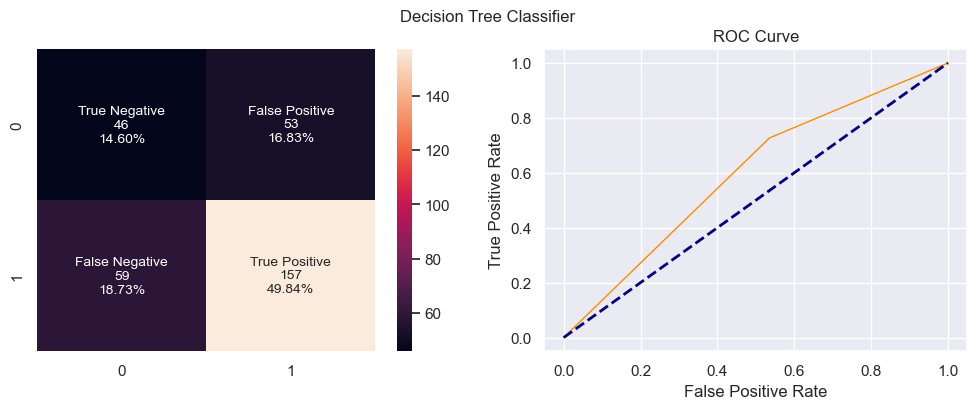

# 2 - Random Forest
               Accuracy  Precision    Recall  F1 Score       ROC
Random Forest  0.704762   0.753086  0.847222  0.797386  0.620581


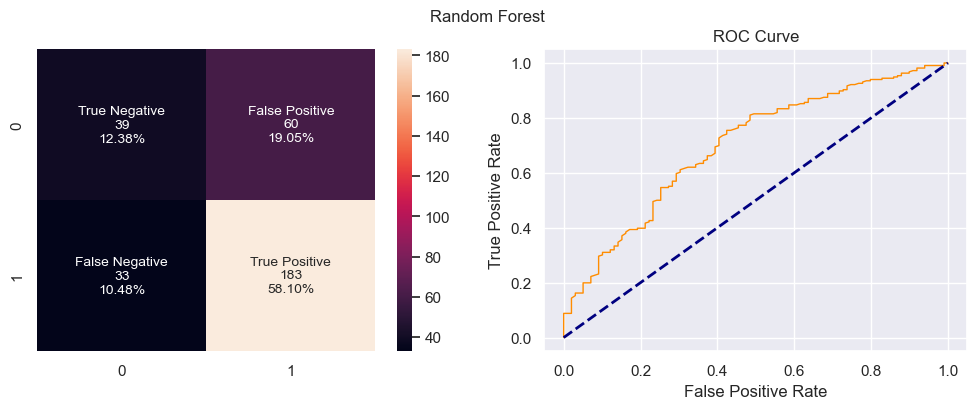

# 3 - Adaboost
          Accuracy  Precision    Recall  F1 Score       ROC
Adaboost  0.704762   0.768559  0.814815  0.791011  0.639731


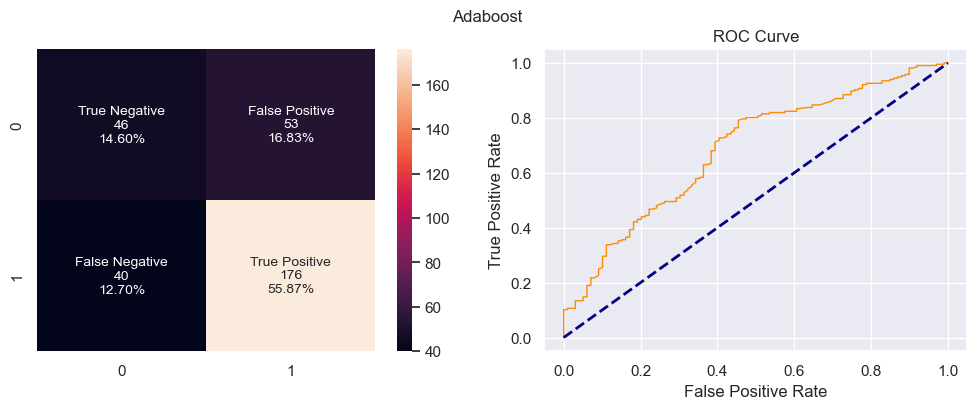

# 4 - Gradient boost classifier
                           Accuracy  Precision    Recall  F1 Score       ROC
Gradient boost classifier  0.714286     0.7625  0.847222  0.802632  0.635732


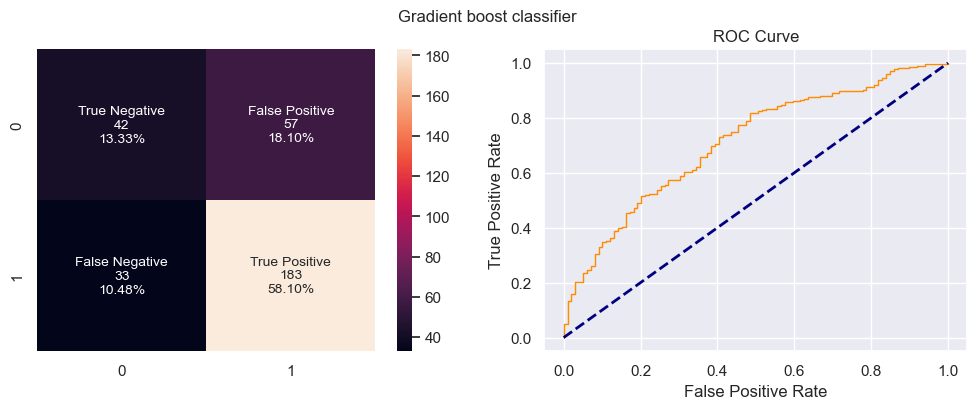

# 5 - XGBoost Classifier
                    Accuracy  Precision    Recall  F1 Score       ROC
XGBoost Classifier  0.707937   0.764957  0.828704  0.795556  0.636574


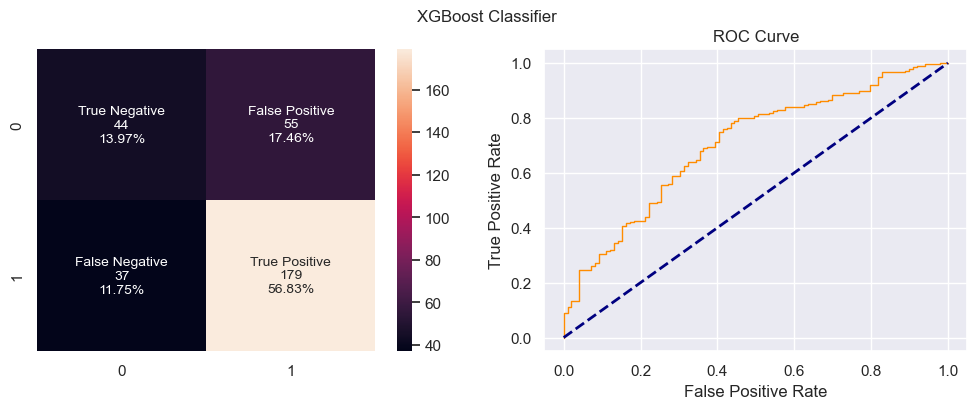

Execution time: 0:00:03.099360


In [74]:
# set starting time
start_time = datetime.now()

# run function to evaluate the performance between classifiers and get the results
prediction_results = classification_prediction(models, x_train, x_test, y_train, y_test)

# set ending time
end_time = datetime.now()

#total execution time
total_time = end_time - start_time

print(f'Execution time: {total_time}')

In [75]:
prediction_results

,Accuracy,Precision,Recall,F1 Score,ROC
Gradient boost classifier,0.714286,0.762500,0.847222,0.802632,0.635732
XGBoost Classifier,0.707937,0.764957,0.828704,0.795556,0.636574
Random Forest,0.704762,0.753086,0.847222,0.797386,0.620581
Adaboost,0.704762,0.768559,0.814815,0.791011,0.639731
Decision Tree Classifier,0.644444,0.747619,0.726852,0.737089,0.595749


* From the above table, we can observe that the **Gradient boost classifier** is the best model regarding accuracy from our classification problem.
* Thus, we will continue our analysis of the remaining depending variables with this model.
* We will check if the belief in supernatural evil, make also a strong showing for all the depending variables.
* For that porpuse we will get the feature importances

Below the feature importances regarding Gradient boost classifier


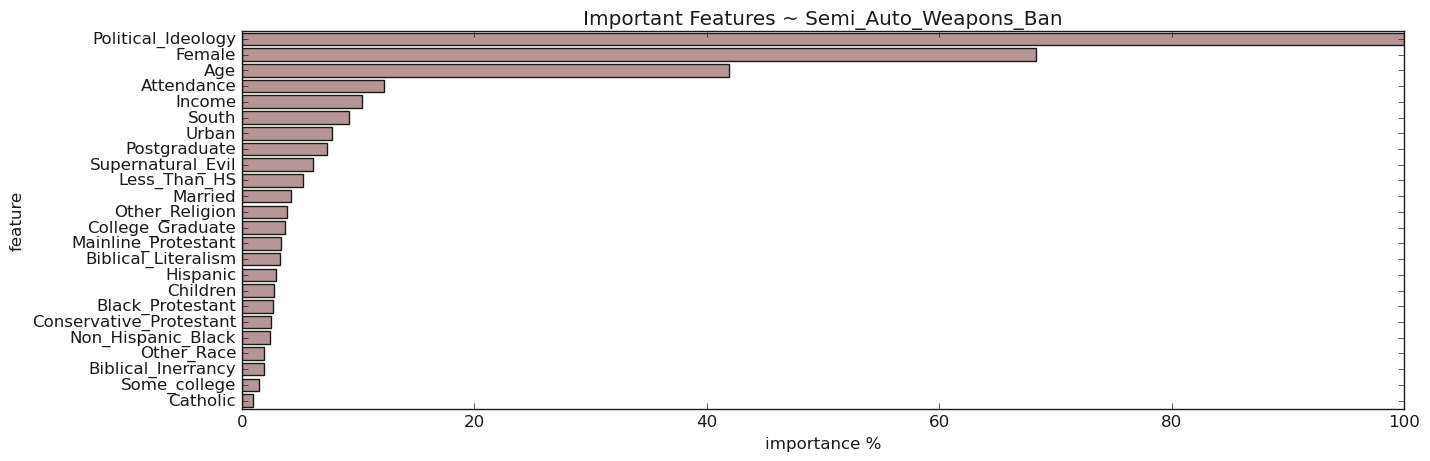

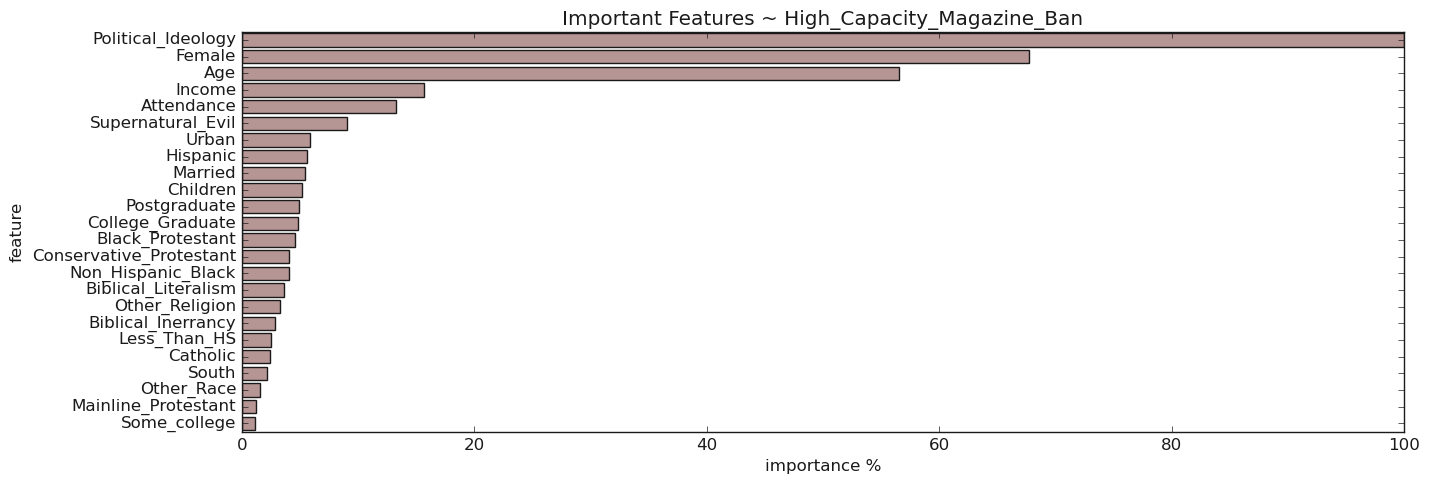

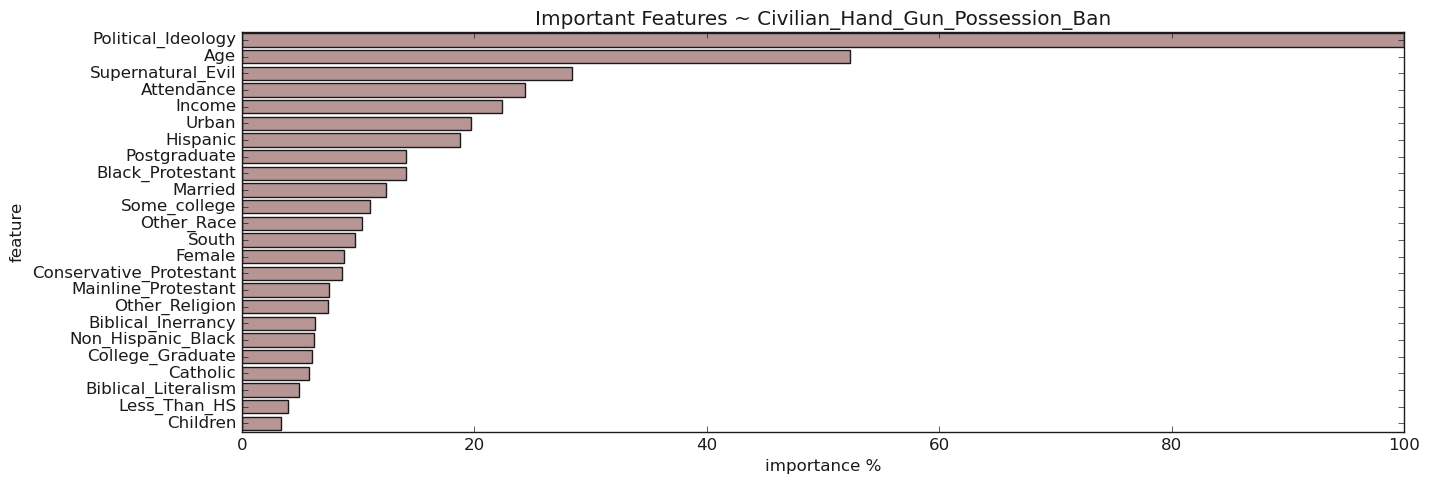

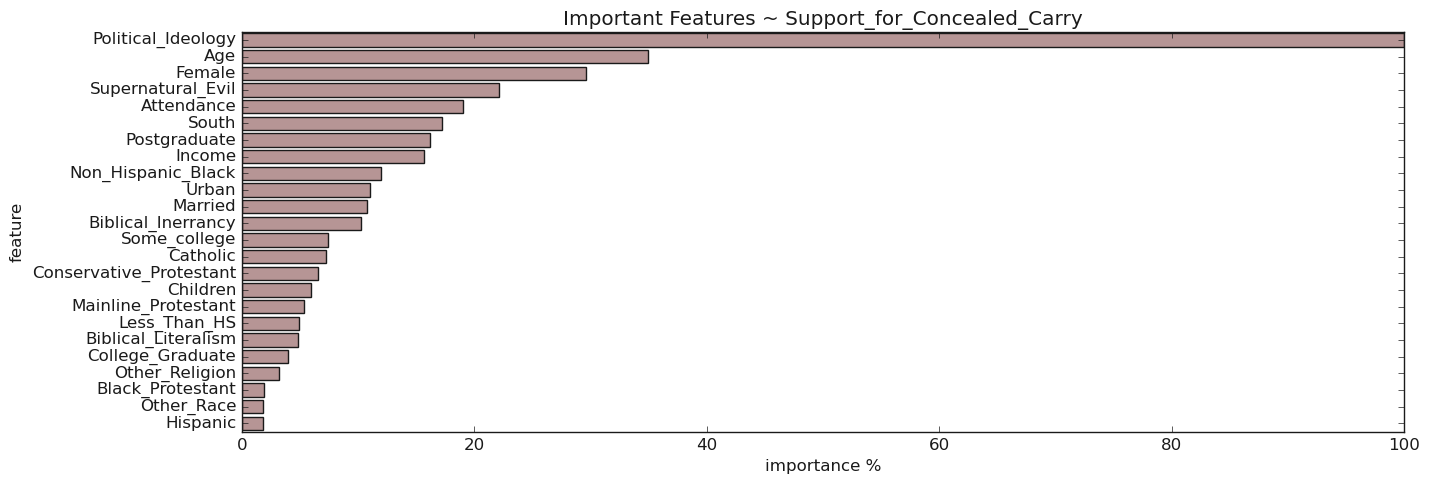

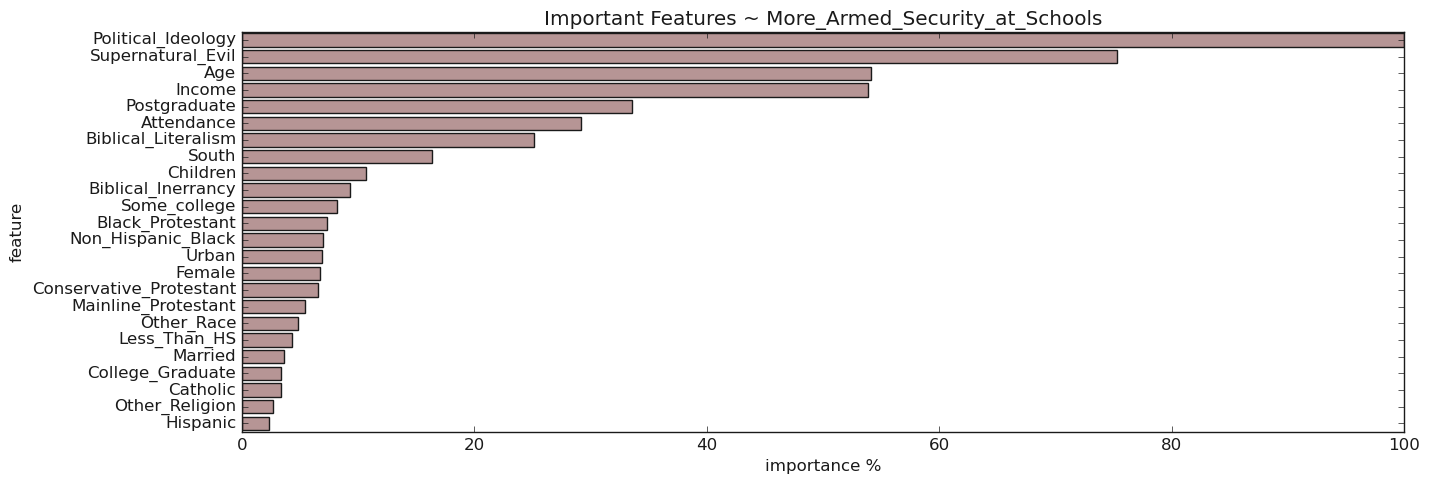

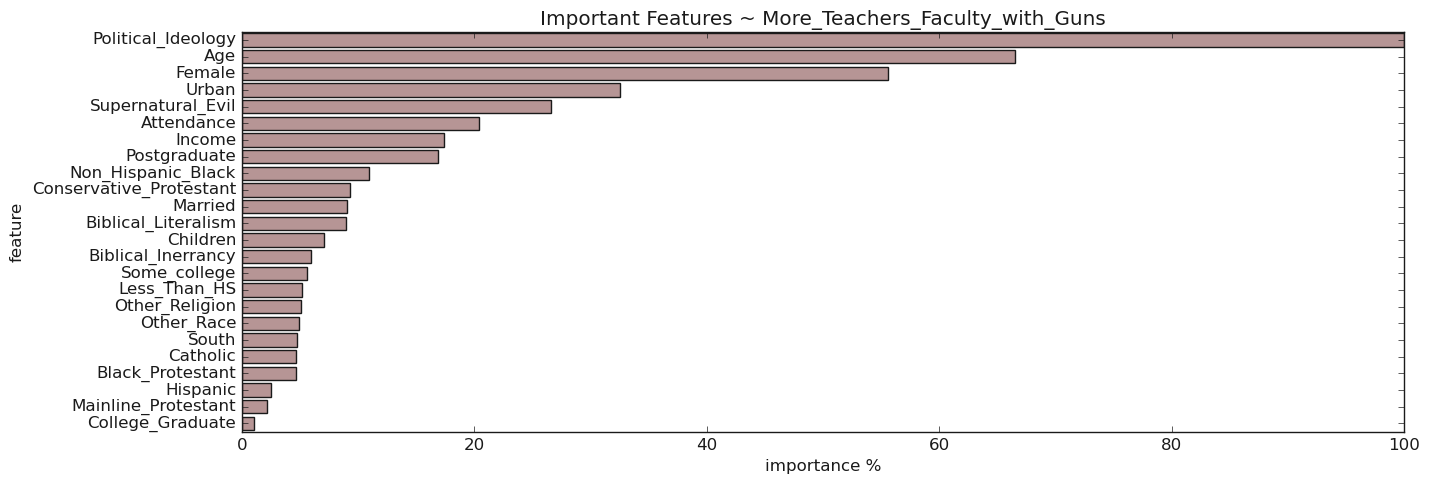

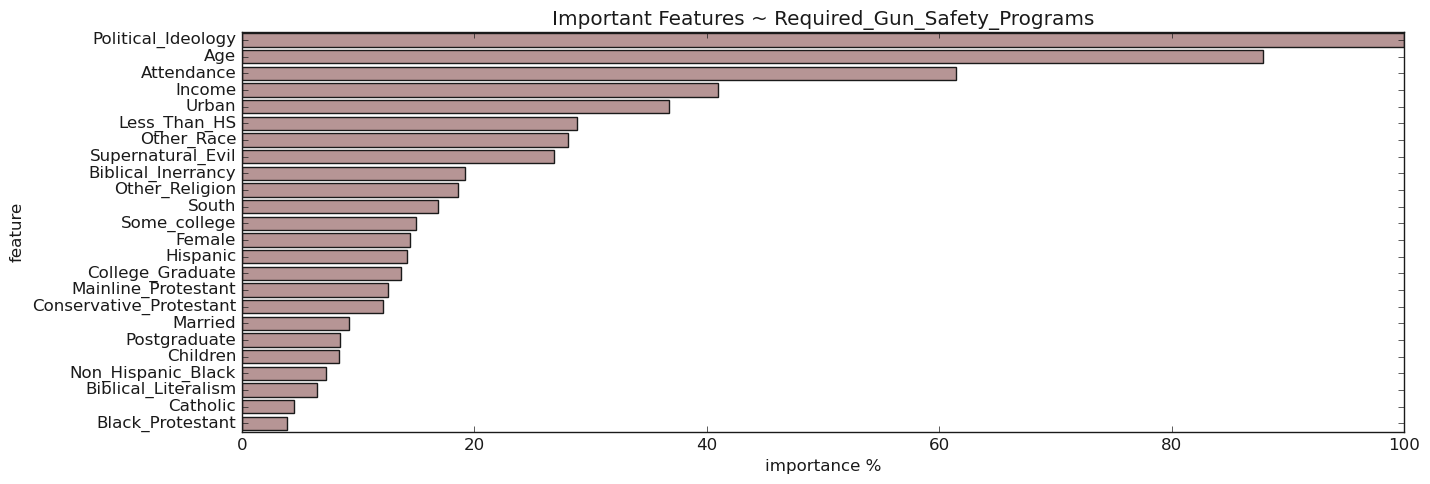

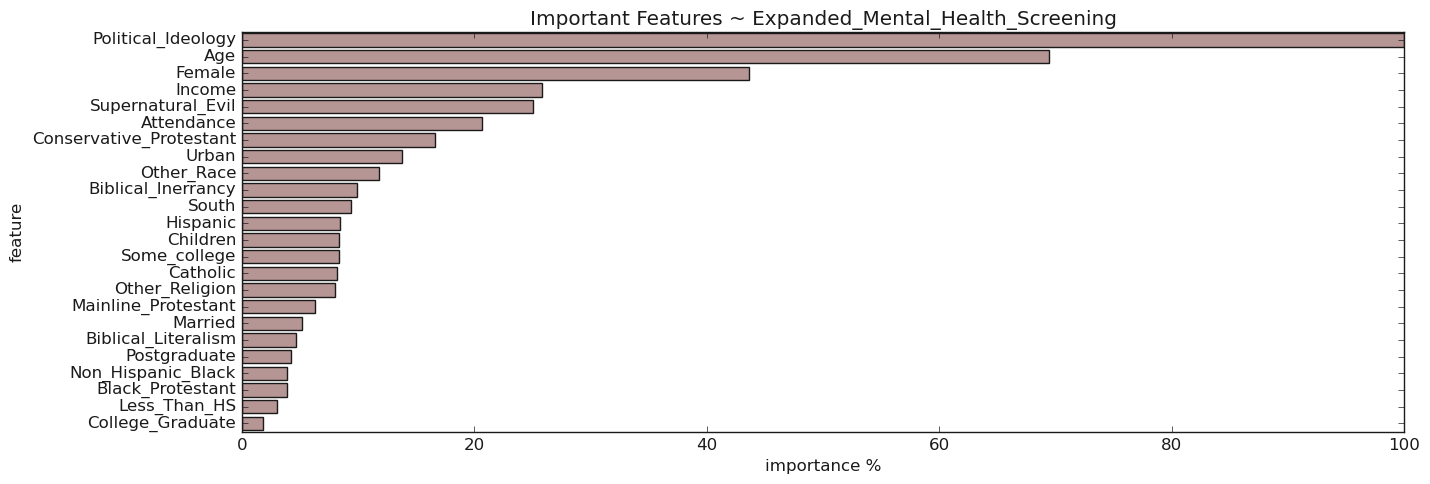

In [76]:
# define our model
model = models[3][1]

print(f'Below the feature importances regarding {models[3][0]}')

# loop through the dependent variables
for dependent in dependent_variables:
    
    # create X,y
    X = df[all_variables]
    y = df[dependent]

    # split into train test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # run function for feature importances
    get_feature_importances(model,dependent,x_train,y_train)
    

### General conclusion 

* Following the application of logistic regression, linear regression, and decision trees, a consistent inference emerged.
* The variable "Supernatural Evil" is identified among the top five feature importances across multiple dimensions, specifically pertaining to attitudes towards policies such as Civilian_Hand_Gun_Possession_Ban, Support_for_Concealed_Carry, More_Armed_Security_at_Schools, Expanded_Mental_Health_Screening, and More_Teachers_Faculty_with_Guns.
* Furthermore, age and political ideology consistently emerge as leading factors, occupying the top three positions in terms of importance across nearly all dependent variables.
* This implies a noteworthy association, wherein individuals endorsing beliefs in Supernatural Evil tend to support pro-gun usage policies. Conversely, attributes such as sex and political ideology surface as pivotal features in variables aligned with advocating for the prohibition of gun usage.